# LeNet-5 #

### 1. Setting ###

In [1]:
# libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
# environments
lr = 1e-3
batch_size = 64
epochs = 20

In [3]:
# device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### 2. MNIST Dataset

In [4]:
# 32 * 32 * 1 MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.MNIST(root="./data", transform=transform, train=True, download=True)
test_data = torchvision.datasets.MNIST(root="./data", transform=transform, train=False, download=True)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### 3. Sample data ###

In [6]:
def show(images, labels, idx):
    img = images[idx].numpy()
    label = labels[idx].numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f"label: {label}")
    plt.axis('off')

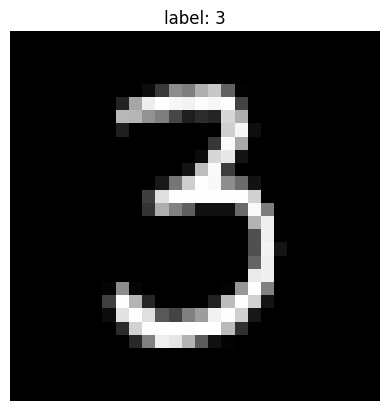

In [7]:
x_sample, y_sample = train_data.data, train_data.targets
show(x_sample, y_sample, 50)

### 4. LeNet-5 Model ###

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=5)
        self.S2 = nn.AvgPool2d(2, stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=5)
        self.S4 = nn.AvgPool2d(2, stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=5)
        self.F6 = nn.Linear(120, 84)
        self.out = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.C1(x)
        x = F.tanh(x)
        x = self.S2(x)
        x = self.C3(x)
        x = F.tanh(x)
        x = self.S4(x)
        x = self.C5(x)
        x = F.tanh(x)
        
        x = torch.flatten(x, 1)
        
        x = self.F6(x)
        x = F.tanh(x)
        x = self.out(x)
        
        probs = F.softmax(x, dim=1)
        
        return x, probs

In [9]:
model = LeNet().to(device)

In [10]:
print(model)

LeNet(
  (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (S2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (S4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (C5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (F6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


### 5. Training ###

In [11]:
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for x, y in train_loader:
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)
        
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        running_loss += loss.item() * x.size(0)
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    
    return model, epoch_loss

In [13]:
def val(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        running_loss += loss.item() * x.size(0)
        
    epoch_loss = running_loss / len(val_loader.dataset)
    
    return epoch_loss

In [14]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model, train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # validation
    with torch.no_grad():
        val_loss = val(model, test_dataloader, criterion, device)
        val_losses.append(val_loss)
        
    if epoch % 5 == 0:
        print(f"Epoch: {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

Epoch: 1/20
Train Loss: 18.2814
Validation Loss: 6.5525
Epoch: 6/20
Train Loss: 1.9262
Validation Loss: 3.1647
Epoch: 11/20
Train Loss: 0.9351
Validation Loss: 2.4871
Epoch: 16/20
Train Loss: 0.4805
Validation Loss: 2.9004


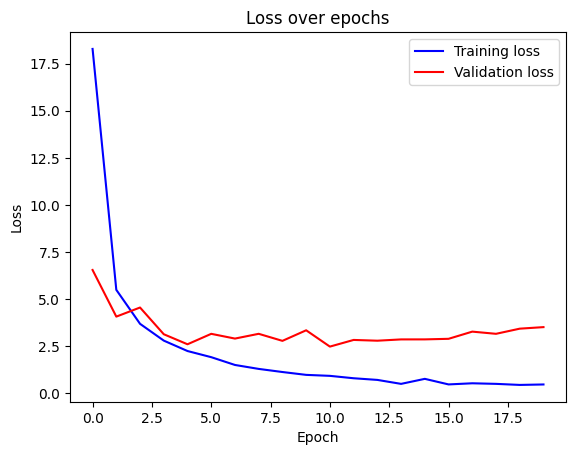

In [15]:
# plot losses
plt.plot(train_losses, color="blue", label="Training loss")
plt.plot(val_losses, color="red", label="Validation loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

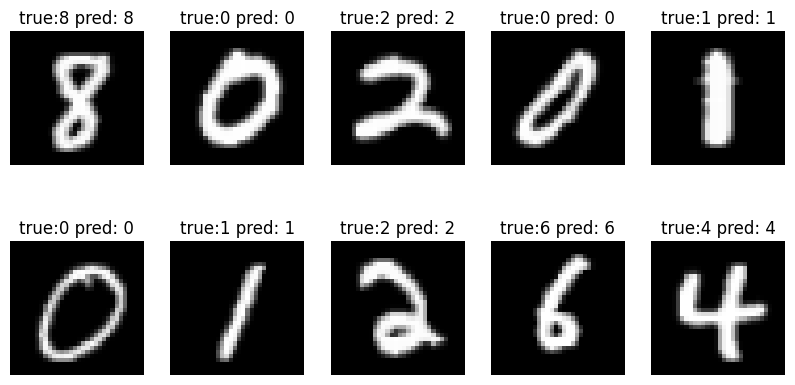

In [24]:
model.to("cpu")
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2

for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    img = torch.unsqueeze(img, 0)
    _, y_pred = model(img)
    
    _, preds = torch.max(y_pred.data, 1)
    
    plt.title(f"true:{label} pred: {preds.item()}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()